# **Создание окружения для работы ImageJ в Google Colab**
---
⛔ **Опасная зона!**
<br>Пожалуйста, не изменяйте и не переносити фрагменты кода из этого раздела.

In [ ]:
# установка JDK8 в Google Colab
import os
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null    # установка openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"    # настройка окружения
    !java -version
!apt update install_java()

In [ ]:
# установка Maven в Google Colab
!sudo apt-get install maven

In [ ]:
# установка PyImageJ в Google Colab
!pip install Cython pyimagej

In [ ]:
# установка PyJnius в Google Colab
!wget https://anaconda.org/conda-forge/pyjnius/1.2.0/download/osx-64/pyjnius-1.2.0-py37h90b5fae_0.tar.bz2 && tar -xjf pyjnius-1.2.0-py37h90b5fae_0.tar.bz2 -C /usr/local
# настройка рабочей среды 
os.environ["PYJNIUS_JAR"] = "/usr/local/share/pyjnius/pyjnius.jar"

In [5]:
# запуск PyImageJ с плагинами Fiji версии 2.9.0/1.53t
import imagej
ij = imagej.init('sc.fiji:fiji:2.9.0')
print(ij.getVersion())

2.9.0/1.53t


In [19]:
# при возникновении проблем с версией 2.9.0/1.53t доступен вызов imagej.init('sc.fiji:fiji'), однако в таком случае не гарантируется работоспособность сценария исполнения команд ImageJ2

# **Автоматизированный анализ изображений средствами PyImageJ**

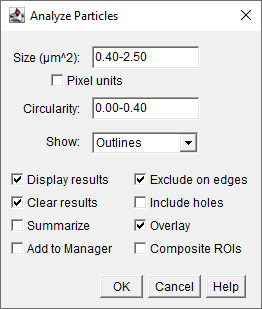

Параметры, используемые при бинаризации изображения:
*   метод установки порога - Triangle (method=Triangle)
*   цвет фона - светлый (background=Light)

Параметры, используемые при анализе частиц:
*   размер 0.40-2.50 мкм.^2 (size=0.40-2.50)
*   округлость 0.00-0.40 (circularity=0.00-0.40)

Оцениваемые характеристики:
*   площадь, мкм.^2 (area)
*   форма = округлость (citcularity)
*   диаметр Фере, мкм. (feret)
*   прочие измерения, связанные с вычислением даиметра Фере, не рассматриваются







In [ ]:
from scyjava import jimport

# сценарий исполнения ImageJ2 команд обработки изображения
imp = ij.IJ.openImage("/content/gmax-2490-28-15-12-2.lsm");
ij.py.run_plugin(plugin="Set Measurements...", args="area shape feret's stack redirect=None decimal=3");
ij.py.run_plugin(imp=imp, plugin="8-bit", args="");
ij.IJ.setAutoThreshold(imp, "Default dark");
ij.py.run_plugin(imp=imp, plugin="Convert to Mask", args="method=Triangle background=Light calculate");
ij.py.run_plugin(imp=imp, plugin="Analyze Particles...", args="size=0.40-2.50 circularity=0.00-0.40 show=Outlines display exclude clear overlay stack");
ij.IJ.saveAs('Results', "/content/Results.csv");

# **Статистическая обработка результатов морфометрического анализа**

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm.notebook import tqdm

Введите в поле ниже название анализируемого образца

In [11]:
sample_name = "gmax-2490-28-15-12-2"

In [16]:
# предобработка данных и очистка выбросов
data_bacteria = pd.read_csv("/content/Results.csv", index_col=0)
slice = data_bacteria.Slice.unique()

for i in slice:
    if i%2!=0:
        data_bacteria = data_bacteria.query('Slice != @i')      

names = ['Feret', 'Area']
for name in names:
    Q1 = data_bacteria[name].quantile(0.25)
    Q3 = data_bacteria[name].quantile(0.75)
    IQR = Q3 - Q1
    Floor = Q1 - IQR * 1.5
    Top = Q3 + IQR * 1.5
    data_bacteria = data_bacteria[data_bacteria[name] >= Floor]
    data_bacteria = data_bacteria[data_bacteria[name] <= Top]
    
display(data_bacteria[['Feret','Area']].describe())

,Feret,Area
count,723.000000,723.000000
mean,2.124072,0.758411
std,0.401958,0.258966
min,1.140000,0.402000
25%,1.845000,0.555000
50%,2.093000,0.708000
75%,2.397000,0.899000
max,3.372000,1.578000


In [17]:
# сохраняем датафрейм с очищенными данными
output_name = 'Results_' + sample_name + '.csv'
data_bacteria.reset_index(drop=True).to_csv(output_name)

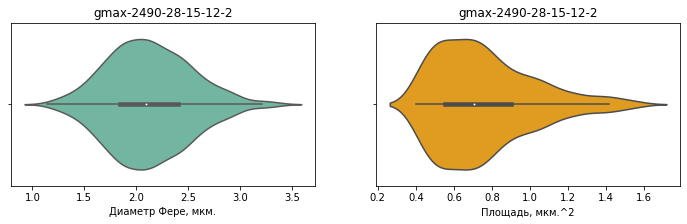

In [18]:
# визуализация диаметра Фере и площади клеток
plt.figure(figsize=(12, 3))

ax1 = plt.subplot(1, 2, 1)
sns.violinplot(data=data_bacteria, x='Feret', palette='Set2')
plt.title(sample_name)
plt.xlabel('Диаметр Фере, мкм.')
plt.grid(False)

ax2 = plt.subplot(1, 2, 2)
sns.violinplot(data=data_bacteria, x='Area', color='Orange')
plt.title(sample_name)
plt.xlabel('Площадь, мкм.^2')
plt.grid(False);